##### __Author:__ Jayson Gutierrez

__Date:__ 6 JUNE 2019

__Outline:__ Exploring single cell data downloaded from the __[Scope single cell data base](http://scope.aertslab.org/#/84fa4e4e-d7ed-47b0-88b5-6b5136cee56d/Aerts_Fly_AdultBrain_Filtered_57k.loom/regulon)__. Loom file is Aerts_Fly_AdultBrain_Filtered_57k.loom, which contains data for ~57000 cells from the Drosophila brain. Note this file is ~700 MB!

Data analyzed is from the following paper: 

> A Single-Cell Transcriptome Atlas of the Aging Drosophila Brain. Cell. 2018 Aug 9;174(4):982-998.e20. doi: 10.1016/j.cell.2018.05.057.

In [5]:
import pandas as pd
import numpy as np
import os, glob, sys
import pickle
import seaborn as sns
import loompy
import matplotlib.pyplot as plt
import networkx as nx
import hdbscan

In [7]:
print(sys.version)

3.6.7 | packaged by conda-forge | (default, Feb 28 2019, 02:16:08) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


#### Connecting to loom file (single cell data base)

In [2]:
ds = loompy.connect("../loom_files/Aerts_Fly_AdultBrain_Filtered_57k.loom")

#### Inspecting attributes of loom file

In [834]:
#Keys for the row attributes data structure. 
raw_atts = ds.ra.keys()
print('Row attributes: ')
print (raw_atts)

print ('\n')

#List of genes used in Scenic to derive the regulons
gene_list = ds.ra['Gene']

print ('\n')

#Keys for the col attributes data structure. 
col_atts = ds.ca.keys()
print('Column attributes: ')
print (col_atts)

print ('\n')

num_genes = len(gene_list)
print ("Number of genes is: ",num_genes)

num_cells = len(ds.ca['CellID'])
print ('Number of cells is: ',num_cells)

print ('\n')


Row attributes: 
['ClusterMarkers_0', 'ClusterMarkers_0_sub_0', 'ClusterMarkers_0_sub_1', 'ClusterMarkers_0_sub_10', 'ClusterMarkers_0_sub_11', 'ClusterMarkers_0_sub_12', 'ClusterMarkers_0_sub_13', 'ClusterMarkers_0_sub_14', 'ClusterMarkers_0_sub_15', 'ClusterMarkers_0_sub_16', 'ClusterMarkers_0_sub_17', 'ClusterMarkers_0_sub_18', 'ClusterMarkers_0_sub_19', 'ClusterMarkers_0_sub_2', 'ClusterMarkers_0_sub_20', 'ClusterMarkers_0_sub_21', 'ClusterMarkers_0_sub_22', 'ClusterMarkers_0_sub_23', 'ClusterMarkers_0_sub_24', 'ClusterMarkers_0_sub_25', 'ClusterMarkers_0_sub_26', 'ClusterMarkers_0_sub_27', 'ClusterMarkers_0_sub_28', 'ClusterMarkers_0_sub_29', 'ClusterMarkers_0_sub_3', 'ClusterMarkers_0_sub_30', 'ClusterMarkers_0_sub_31', 'ClusterMarkers_0_sub_32', 'ClusterMarkers_0_sub_33', 'ClusterMarkers_0_sub_34', 'ClusterMarkers_0_sub_35', 'ClusterMarkers_0_sub_36', 'ClusterMarkers_0_sub_37', 'ClusterMarkers_0_sub_38', 'ClusterMarkers_0_sub_39', 'ClusterMarkers_0_sub_4', 'ClusterMarkers_0_sub_

Check some of the IDs

In [929]:
pd.Series(np.array(["_".join(i) for i in ds.ca['ClusterID'].astype(int).astype(str)])).value_counts().iloc[:10]

1_1_5_4_3_2_3_2_1         282
0_0_0_0_4_3_1_1_0         257
0_0_0_0_6_6_9_8_1         256
0_0_0_0_4_3_1_1_4         245
3_3_2_2_0_15_13_4_0       230
7_7_7_6_7_5_5_5_0         219
4_4_3_3_24_24_25_25_0     219
6_6_9_10_17_16_15_63_0    219
5_5_4_5_2_1_2_0_0         198
0_0_0_0_4_3_1_1_3         190
dtype: int64

Fetch all the different age classes

In [235]:
age_class = pd.Series(ds.ca['Age'].tolist()).value_counts()
age_class.index = wea.index.values.astype(int)
unique_age_class = age_class.sort_index().index.values.astype(str)

#### Based on the tSNE embedding included in the loom file, here we single out cell types

In [1009]:
#grab tSNE embedding (obtained via Seurat?)
tsne_embedding = np.array(list(map(list,ds.ca['Embedding'])))

#Run clustering analysis via HDBSCAN
clusterer = hdbscan.HDBSCAN()
clusterer.fit(tsne_embedding);
memb_probab = 0.99


#grab only those points that were assigned high probab (>=0.9) to be allocated in a given cluster
high_probab_points = np.where(clusterer.probabilities_ >= memb_probab)[0]
prunned_cls_lbs = clusterer.labels_[high_probab_points]

#assess the enrichment of clusters for high probab points: highly dense clusters, e.g. allocating > 50 data points
cls_enrichment = pd.Series(prunned_cls_lbs).value_counts()
prunned_cls_enrichment = cls_enrichment[cls_enrichment>50]

print("Total number of cells assigned to high density clusters: ",prunned_cls_enrichment.sum())

#Clusters ids
high_density_cls_ids = prunned_cls_enrichment.index.values

N = high_density_cls_ids.shape[0]

Total number of cells assigned to high density clusters:  11426


Plotting tSNE embedding for the SCenic dataset (i.e. regulon activity matrix)

In [1010]:
import colorsys
import random

In [1011]:
def get_N_HexCol(N=5):
    HSV_tuples = [(x * 1.0 / N, 0.5, 0.5) for x in range(N)]
    hex_out = []
    for rgb in HSV_tuples:
        rgb = map(lambda x: int(x * 255), colorsys.hsv_to_rgb(*rgb))
        hex_out.append('#%02x%02x%02x' % tuple(rgb))
    return hex_out

Create own color list

In [1012]:
cnames = {
    'aliceblue'            : '#F0F8FF',
    'antiquewhite'         : '#FAEBD7',
    'aqua'                 : '#00FFFF',
    'aquamarine'           : '#7FFFD4',
    'azure'                : '#F0FFFF',
    'beige'                : '#F5F5DC',
    'bisque'               : '#FFE4C4',
    'black'                : '#000000',
    'blanchedalmond'       : '#FFEBCD',
    'blue'                 : '#0000FF',
    'blueviolet'           : '#8A2BE2',
    'brown'                : '#A52A2A',
    'burlywood'            : '#DEB887',
    'cadetblue'            : '#5F9EA0',
    'chartreuse'           : '#7FFF00',
    'chocolate'            : '#D2691E',
    'coral'                : '#FF7F50',
    'cornflowerblue'       : '#6495ED',
    'cornsilk'             : '#FFF8DC',
    'crimson'              : '#DC143C',
    'cyan'                 : '#00FFFF',
    'darkblue'             : '#00008B',
    'darkcyan'             : '#008B8B',
    'darkgoldenrod'        : '#B8860B',
    'darkgray'             : '#A9A9A9',
    'darkgreen'            : '#006400',
    'darkkhaki'            : '#BDB76B',
    'darkmagenta'          : '#8B008B',
    'darkolivegreen'       : '#556B2F',
    'darkorange'           : '#FF8C00',
    'darkorchid'           : '#9932CC',
    'darkred'              : '#8B0000',
    'darksalmon'           : '#E9967A',
    'darkseagreen'         : '#8FBC8F',
    'darkslateblue'        : '#483D8B',
    'darkslategray'        : '#2F4F4F',
    'darkturquoise'        : '#00CED1',
    'darkviolet'           : '#9400D3',
    'deeppink'             : '#FF1493',
    'deepskyblue'          : '#00BFFF',
    'dimgray'              : '#696969',
    'dodgerblue'           : '#1E90FF',
    'firebrick'            : '#B22222',
    'floralwhite'          : '#FFFAF0',
    'forestgreen'          : '#228B22',
    'fuchsia'              : '#FF00FF',
    'gainsboro'            : '#DCDCDC',
    'ghostwhite'           : '#F8F8FF',
    'gold'                 : '#FFD700',
    'goldenrod'            : '#DAA520',
    'gray'                 : '#808080',
    'green'                : '#008000',
    'greenyellow'          : '#ADFF2F',
    'honeydew'             : '#F0FFF0',
    'hotpink'              : '#FF69B4',
    'indianred'            : '#CD5C5C',
    'indigo'               : '#4B0082',
    'ivory'                : '#FFFFF0',
    'khaki'                : '#F0E68C',
    'lavender'             : '#E6E6FA',
    'lavenderblush'        : '#FFF0F5',
    'lawngreen'            : '#7CFC00',
    'lemonchiffon'         : '#FFFACD',
    'lightblue'            : '#ADD8E6',
    'lightcoral'           : '#F08080',
    'lightcyan'            : '#E0FFFF',
    'lightgoldenrodyellow' : '#FAFAD2',
    'lightgreen'           : '#90EE90',
    'lightgrey'            : '#D3D3D3',
    'lightpink'            : '#FFB6C1',
    'lightsalmon'          : '#FFA07A',
    'lightseagreen'        : '#20B2AA',
    'lightskyblue'         : '#87CEFA',
    'lightslategray'       : '#778899',
    'lightsteelblue'       : '#B0C4DE',
    'lightyellow'          : '#FFFFE0',
    'lime'                 : '#00FF00',
    'limegreen'            : '#32CD32',
    'linen'                : '#FAF0E6',
    'magenta'              : '#FF00FF',
    'maroon'               : '#800000',
    'mediumaquamarine'     : '#66CDAA',
    'mediumblue'           : '#0000CD',
    'mediumorchid'         : '#BA55D3',
    'mediumpurple'         : '#9370DB',
    'mediumseagreen'       : '#3CB371',
    'mediumslateblue'      : '#7B68EE',
    'mediumspringgreen'    : '#00FA9A',
    'mediumturquoise'      : '#48D1CC',
    'mediumvioletred'      : '#C71585',
    'midnightblue'         : '#191970',
    'mintcream'            : '#F5FFFA',
    'mistyrose'            : '#FFE4E1',
    'moccasin'             : '#FFE4B5',
    'navajowhite'          : '#FFDEAD',
    'navy'                 : '#000080',
    'oldlace'              : '#FDF5E6',
    'olive'                : '#808000',
    'olivedrab'            : '#6B8E23',
    'orange'               : '#FFA500',
    'orangered'            : '#FF4500',
    'orchid'               : '#DA70D6',
    'palegoldenrod'        : '#EEE8AA',
    'palegreen'            : '#98FB98',
    'palevioletred'        : '#AFEEEE',
    'papayawhip'           : '#FFEFD5',
    'peachpuff'            : '#FFDAB9',
    'peru'                 : '#CD853F',
    'pink'                 : '#FFC0CB',
    'plum'                 : '#DDA0DD',
    'powderblue'           : '#B0E0E6',
    'purple'               : '#800080',
    'red'                  : '#FF0000',
    'rosybrown'            : '#BC8F8F',
    'royalblue'            : '#4169E1',
    'saddlebrown'          : '#8B4513',
    'salmon'               : '#FA8072',
    'sandybrown'           : '#FAA460',
    'seagreen'             : '#2E8B57',
    'seashell'             : '#FFF5EE',
    'sienna'               : '#A0522D',
    'silver'               : '#C0C0C0',
    'skyblue'              : '#87CEEB',
    'slateblue'            : '#6A5ACD',
    'slategray'            : '#708090',
    'snow'                 : '#FFFAFA',
    'springgreen'          : '#00FF7F',
    'steelblue'            : '#4682B4',
    'tan'                  : '#D2B48C',
    'teal'                 : '#008080',
    'thistle'              : '#D8BFD8',
    'tomato'               : '#FF6347',
    'turquoise'            : '#40E0D0',
    'violet'               : '#EE82EE',
    'wheat'                : '#F5DEB3',
    'white'                : '#FFFFFF',
    'whitesmoke'           : '#F5F5F5',
    'yellow'               : '#FFFF00',
    'yellowgreen'          : '#9ACD32',
    }

In [1021]:
#Generate colors for the high density clusters, while any other cluster will be color-coded in black
condition = True
while(condition):
    high_dens_cls_colors = np.random.choice(np.array(list(cnames.keys())),N,replace=False)
    condition = ("black" in high_dens_cls_colors) & ("white" in high_dens_cls_colors)

hdclsid2colr = dict(zip(high_density_cls_ids,high_dens_cls_colors))

#Let's create the color list
color_list = []
for clid in clusterer.labels_[high_probab_points]:
    if(clid in hdclsid2colr.keys()):
        color_list.append(hdclsid2colr[clid])
    else: #append hex for black
        color_list.append("#000000")
        
color_array = np.array(color_list)        

Visualizing tSEN embedding: only dense clusters were colored

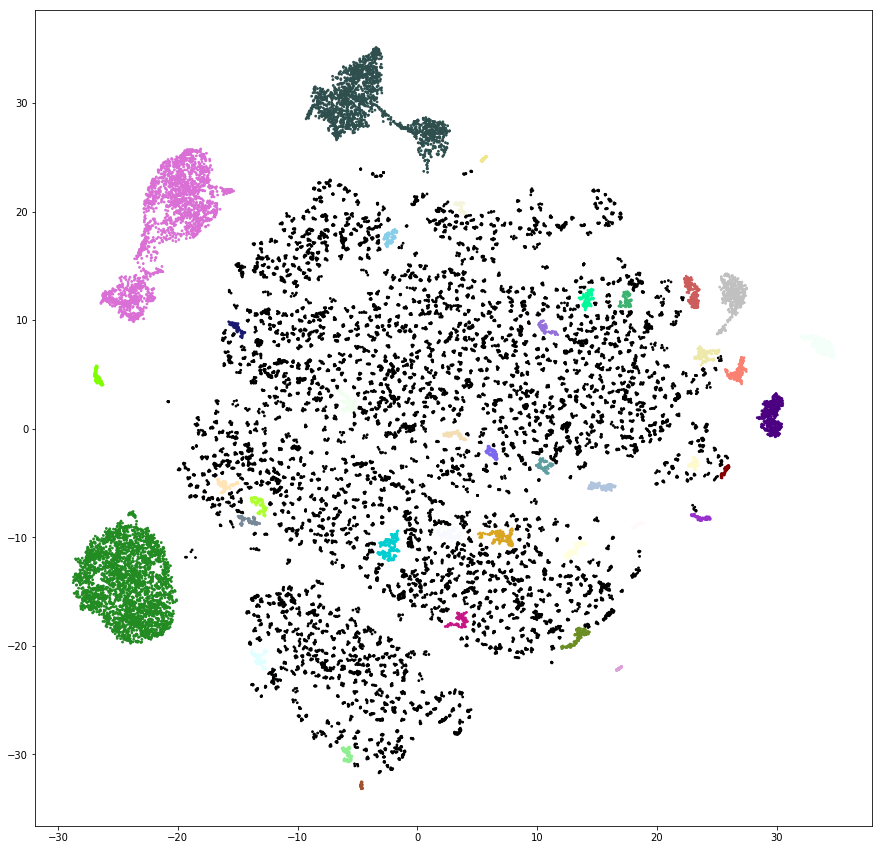

In [1022]:
plt.figure(figsize=(15,15))

plt.scatter(tsne_embedding[high_probab_points,0],
            tsne_embedding[high_probab_points,1],
            c=color_array,
            s=3)

plt.show()

#### Let's create a df relating cell_id to cluster membership in the reduced embedding displayed above. Use this df to compare GRN topology heterogeinity within clusters of similar cell types, or among distinct clusters of cell types

In [1024]:
cell_ids_cont = []
cls_ids_cont = []

for cl in high_density_cls_ids:

    ids_in_dataset = high_probab_points[prunned_cls_lbs==cl]
    cell_ids_cont.append(ds.ca['CellID'][ids_in_dataset].tolist())
    
    cls_ids_cont.append(np.repeat(cl,len(ids_in_dataset)).tolist())

In [1025]:
#Flatten lists out to create df
flattened_list0 = [y for x in cell_ids_cont for y in x]
flattened_list1 = [y for x in cls_ids_cont for y in x]
reduced_embed_df = pd.DataFrame(data=list(zip(flattened_list0,flattened_list1)),
                                columns=['CellID','ClusterMembership'])

In [1026]:
reduced_embed_df.shape

(11426, 2)

#### Let's extract the adjacency graph (i.e. TF-TF network topology) for all the different clustered cells. Based on this info, the idea is to compare GRN topology heterogeinity within clusters of similar cell types, or among distinct clusters of cell types

Uncomment code below to re-run for extracting adjacency graphs based on e.g. a different criterion for RegulonsAUC

In [851]:
# upper_bound = 90 # set percentile for the regulon AUC distribution for this particular cell type

# for n in range(reduced_embed_df.shape[0]):
    
#     cell_type = reduced_embed_df.iloc[n]['CellID']
#     cell_id = np.where(ds.ca['CellID']==cell_type)[0][0]
#     cls_memb = str(reduced_embed_df.iloc[n]['ClusterMembership'])
    
#     #Fetch data for cell type defined by cell_id
#     cell_view_ds = ds.view[:, int(cell_id)]

#     #The following gives the regulons IDs
#     regulons_ids = np.array(list(cell_view_ds.ra['Regulons'].dtype.fields.keys())).astype(str)

#     #This gives the distribution of AUC scores per regulon in a given cell type
#     regulonsAUC_per_cell_type = np.array(cell_view_ds.ca['RegulonsAUC'].tolist())

#     #Setting the threshold for regulon AUC. Setting this to a stringent value
#     regulonsAUC_trh = np.percentile(regulonsAUC_per_cell_type,upper_bound)

#     #This gives the active regulons in this particular cell type, based on the AUC score
#     active_regulons_ids = regulons_ids[np.where(regulonsAUC_per_cell_type>=regulonsAUC_trh)[0]]

#     #The following matrix relates the regulon ID active in a given cell type. 
#     #The matrix is a NxM --> e.g. N = 17473 genes, M = 150 regulons
#     regulons_matrix = np.array(cell_view_ds.ra['Regulons'].tolist()).astype(int)

#     #Cast regulon data for cell type into a df
#     cell_type_regulons_df = pd.DataFrame(data=regulons_matrix,
#                                          index=cell_view_ds.ra['Gene'].astype(str),
#                                          columns=regulons_ids)

#     #Assess cross regulation between TFs that make up regulons
#     target_tfs_ids = [s.split('_')[0] for s in active_regulons_ids]
#     #Create a df relating TF cross-regulation
#     tf2tf_regulation_df = cell_type_regulons_df[active_regulons_ids].loc[target_tfs_ids]
#     tf2tf_regulation_df.columns = target_tfs_ids

#     #Save TF-TF cross regulation matrix as a df
#     fn = "Cluster{}TFTFW_{}.csv".format(cls_memb,cell_type)
#     full_fn = "../output_data2/{}".format(fn)
#     tf2tf_regulation_df.to_csv(full_fn)        

#### Casting file names for TF-TF topologies into a dict

In [865]:
reduced_embed_groupedby = reduced_embed_df.groupby(by='ClusterMembership')

cell_type_cls2cellid = {}

for (cm,df) in reduced_embed_groupedby:
    
    full_fn_cont = []
    
    for ct in df['CellID'].values:    

        fn = "Cluster{}TFTFW_{}.csv".format(str(cm),ct)
        full_fn = "../output_data2/{}".format(fn)
        full_fn_cont.append(full_fn)
        
    cell_type_cls2cellid[str(cm)] = np.array(full_fn_cont)

In [896]:
#Save file names: use this within e.g. Mathematica for network/graph analysis
for k in cell_type_cls2cellid.keys():
    cls_fns = cell_type_cls2cellid[k]
    np.savetxt("../output_data2/Cluster{}CellTypes.txt".format(k),cls_fns,fmt="%s")

The following list illustrates total number of outgoing links from a set of TFs found to form a dense regulatory circuit

In [1040]:
pd.read_csv(cls_fns[0],index_col='Unnamed: 0').sum(axis=0)

acj6         1
bru3         3
CG9650       2
crol         3
dati         2
ey           1
FoxP         7
l(3)neo38    4
lola         2
onecut       7
Optix        2
Pdp1         6
SoxN         5
Tet          6
toy          3
dtype: int64

### The panel shown below illustrates conserved regulatory motifs of TF-TF interactions across the different clusters of cell types inferred based on the regulon activity distribution generated via the regulon scoring pipeling known as __[Scenic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5937676/)__.  
NOTE: These are the connected components most frequently observed across the different clusters of cells inferred. See Mathematica notebook: NetWiringAnalysis1.nb

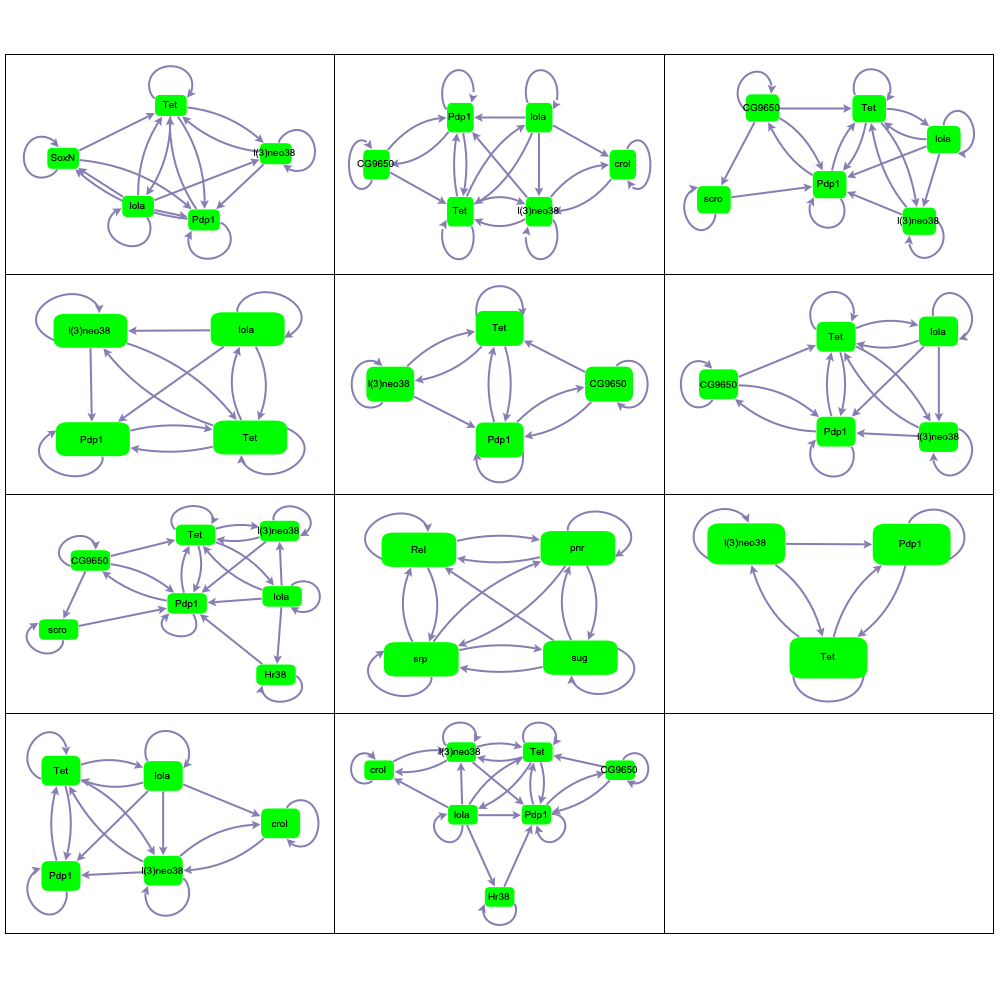

In [1047]:
from IPython.display import Image
Image("figures/PervalentRegulatoryMotifsOverall.png")

####----------------------------------------------------------------------------------------------------------------------####   
Code below was just for exploratory purposes!!!!

#### Here we sort cell types (given by their CellID tag) according to young (0days) and old (50days) status. Based on this one can then compare how the wiring between TFs that make up regulons changes as a given cell type gets older

In [631]:
# #fetch unique cell types, which can be younger or older
# cell_ids = [s.split("-")[0] for s in ds.ca['CellID']]
# cell_ids_series = pd.Series(cell_ids).value_counts()

# #grab unique cell types by ages: 0d vs. 50d
# cellid2age_dict = {}
# for idx in cell_ids_series.index:
#     #filter first by nucleotide tag/genotype
#     l0 = [s for s in ds.ca['CellID'] if idx in s]
#     #then filter by age, i.e. 0d and 50d, etc.
#     l0d = [s0 for s0 in l0 if "_0d_" in s0]
#     l50d = [s1 for s1 in l0 if "_50d_" in s1]
#     #cast into a dict young and old cells of the same type
#     if( (len(l0d)>0) & (len(l50d)>0) ):
#         cellid2age_dict[idx] = [l0d,l50d]
        
        
# #Casting data into a df
# age_paired_cell_types = pd.DataFrame(data=[np.array(l).flatten().tolist() for l in list(cellid2age_dict.values())],
#                                      columns=['Age_0_days','Age_50_days'], index=list(cellid2age_dict.keys()))
# #save to .csv
# age_paired_cell_types.to_csv('../output_data/AgePairedCellTypes.csv')        

#### Sorted some cell types by age: 0 days vs 50 days

In [661]:
age_paired_cell_types = pd.read_csv('../output_data/AgePairedCellTypes.csv',index_col='Unnamed: 0')

#### Let's extract the adjacency graph (i.e. TF-TF network topology) for the age-paired cell types. Based on this info, the idea is to assess changes in the wiring of the TF-TF cross-regulatory network for a given cell type at different ages, i.e. 0-day vs 50-days. NOTE: this is just a preliminary analysis that allows to make sense out of the multi-layered dataset contained in the loom file

In [698]:
upper_bound = 90 # set percentile for the regulon AUC distribution for this particular cell type

for n in range(age_paired_cell_types.shape[0]):
    
    cell_types = age_paired_cell_types.iloc[n].values
    cell_ids = [np.where(ds.ca['CellID']==i)[0][0] for i in cell_types]
    
    for (idx, lbl) in zip(cell_ids,cell_types):

        #Fetch data for cell type defined by cell_id
        cell_view_ds = ds.view[:, int(idx)]

        #The following gives the regulons IDs
        regulons_ids = np.array(list(cell_view_ds.ra['Regulons'].dtype.fields.keys())).astype(str)

        #This gives the distribution of AUC scores per regulon in a given cell type
        regulonsAUC_per_cell_type = np.array(cell_view_ds.ca['RegulonsAUC'].tolist())

        #Setting the threshold for regulon AUC. Setting this to a stringent value
        regulonsAUC_trh = np.percentile(regulonsAUC_per_cell_type,upper_bound)

        #This gives the active regulons in this particular cell type, based on the AUC score
        active_regulons_ids = regulons_ids[np.where(regulonsAUC_per_cell_type>=regulonsAUC_trh)[0]]

        #The following matrix relates the regulon ID active in a given cell type. 
        #The matrix is a NxM --> e.g. N = 17473 genes, M = 150 regulons
        regulons_matrix = np.array(cell_view_ds.ra['Regulons'].tolist()).astype(int)

        #Cast regulon data for cell type into a df
        cell_type_regulons_df = pd.DataFrame(data=regulons_matrix,
                                             index=cell_view_ds.ra['Gene'].astype(str),
                                             columns=regulons_ids)

        #Assess cross regulation between TFs that make up regulons
        target_tfs_ids = [s.split('_')[0] for s in active_regulons_ids]
        #Create a df relating TF cross-regulation
        tf2tf_regulation_df = cell_type_regulons_df[active_regulons_ids].loc[target_tfs_ids]
        tf2tf_regulation_df.columns = target_tfs_ids

        #Save TF-TF cross regulation matrix as a df
        fn = "TFTFW_{}.csv".format(lbl)
        full_fn = "../output_data/{}".format(fn)
        tf2tf_regulation_df.to_csv(full_fn)        

#### Let's focus on all cell types

In [535]:
cell_id = 20000 # chose cell type
upper_bound = 90 # set percentile for the regulon AUC distribution for this particular cell type

In [699]:
# for cell_id in range(num_cells):

#     #Fetch data for cell type defined by cell_id
#     cell_view_ds = ds.view[:, cell_id]

#     #The following gives the regulons IDs
#     regulons_ids = np.array(list(cell_view_ds.ra['Regulons'].dtype.fields.keys())).astype(str)

#     #This gives the distribution of AUC scores per regulon in a given cell type
#     regulonsAUC_per_cell_type = np.array(cell_view_ds.ca['RegulonsAUC'].tolist())

#     #Setting the threshold for regulon AUC. Setting this to a stringent value
#     regulonsAUC_trh = np.percentile(regulonsAUC_per_cell_type,upper_bound)

#     #This gives the active regulons in this particular cell type, based on the AUC score
#     active_regulons_ids = regulons_ids[np.where(regulonsAUC_per_cell_type>=regulonsAUC_trh)[0]]

#     #The following matrix relates the regulon ID active in a given cell type. 
#     #The matrix is a NxM --> e.g. N = 17473 genes, M = 150 regulons
#     regulons_matrix = np.array(cell_view_ds.ra['Regulons'].tolist()).astype(int)

#     #Cast regulon data for cell type into a df
#     cell_type_regulons_df = pd.DataFrame(data=regulons_matrix,
#                                          index=cell_view_ds.ra['Gene'].astype(str),
#                                          columns=regulons_ids)

#     #Assess cross regulation between TFs that make up regulons
#     target_tfs_ids = [s.split('_')[0] for s in active_regulons_ids]
#     #Create a df relating TF cross-regulation
#     tf2tf_regulation_df = cell_type_regulons_df[active_regulons_ids].loc[target_tfs_ids]
#     tf2tf_regulation_df.columns = target_tfs_ids

#     #Save TF-TF cross regulation matrix as a df
#     fn = "TFTFW_{}.csv".format(cell_view_ds.ca['CellID'])
#     full_fn = "../output_data/{}".format(fn)
#     tf2tf_regulation_df.to_csv(full_fn)

# Conclusion: 
Taken together, these preliminary analyses of single cell data extracted from the Scope data base show a great heterogeneity in in the regulatory circuit wiring underlying single cell transcriptomes in the Drosphila brain